# How can frog grow its tail back?


In [2]:
!pip install anndata
!pip install 'scanpy[leiden]'
!pip install 'scanpy[louvain]'
!pip install 'scanpy[umap]'


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In this starter we provide some built-in functions for PCA and subsequent Leiden Clustering. We do not reqruire you write down PCA in this task, but for more details as to how you should use it, `scanpy` uses the `sklearn` PCA routine - for `R` users, there might be some usage discrepancies. Scaling/centering data is not automatically done and can be a careful choice here. For additional information on single cell specific use, you can consult this [tutorial](https://training.galaxyproject.org/training-material/topics/single-cell/tutorials/scrna-scanpy-pbmc3k/tutorial.html#dimensionality-reduction).


For the project, ask yourself some questions: why do we do PCA? how does this affect our data? how does the scaling affect? should we scale? what is the impact of the processing steps? does the interpretation carry over from classical ML use? How does the two formulations of PCA help you understand what is going on here?

## Processing the data

In [4]:
import scanpy as sc
extract_dir = "/content/drive/MyDrive/Frogtail_files/" # use your own directory
adata = sc.read_h5ad(extract_dir+'cleaned_processed_frogtail.h5ad') # file path

/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [5]:
adata.X

<13199x31535 sparse matrix of type '<class 'numpy.int64'>'
	with 29297098 stored elements in Compressed Sparse Row format>

In [6]:
adata.obs

,barcode_cells,cell,sample,DevelopmentalStage,DaysPostAmputation,cluster,X,Y,CellCyclePhase,Sample,Lane,Condition,batch
0,AAACCTGAGCTAGTTC.1,AAACCTGAGCTAGTTC.1,SIGAB5,st40,3,Erythrocyte 4,-6.395430,0.832323,G2M,SIGAB5,SLX-15583,ST40_3,3
1,AAACCTGGTGGGTCAA.1,AAACCTGGTGGGTCAA.1,SIGAB5,st40,3,Myeloid 1,-2.428271,13.826715,G1,SIGAB5,SLX-15583,ST40_3,3
2,AAACCTGGTTTGTTGG.1,AAACCTGGTTTGTTGG.1,SIGAB5,st40,3,Beta ionocyte,-1.398049,-14.653897,G1,SIGAB5,SLX-15583,ST40_3,3
3,AAACGGGGTCGGCATC.1,AAACGGGGTCGGCATC.1,SIGAB5,st40,3,Erythrocyte 4,-5.863765,0.489598,G2M,SIGAB5,SLX-15583,ST40_3,3
4,AAACGGGTCCTACAGA.1,AAACGGGTCCTACAGA.1,SIGAB5,st40,3,Goblet cell,2.106444,-6.594430,G1,SIGAB5,SLX-15583,ST40_3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13194,TTCTTAGAGTACCGGA.1,TTCTTAGAGTACCGGA.1,SIGAB10,st40,3,Erythrocyte 4,-5.879582,0.924197,G2M,SIGAB10,SLX-15739,ST40_3,4
13195,TTGACTTAGAGTAAGG.1,TTGACTTAGAGTAAGG.1,SIGAB10,st40,3,Goblet cell,1.252149,-8.870151,G1,SIGAB10,SLX-15739,ST40_3,4
13196,TTGCGTCTCAAGAAGT.1,TTGCGTCTCAAGAAGT.1,SIGAB10,st40,3,Goblet cell,0.693335,-9.168521,G1,SIGAB10,SLX-15739,ST40_3,4
13197,TTGTAGGCAGTACACT.1,TTGTAGGCAGTACACT.1,SIGAB10,st40,3,Erythrocyte 1,-4.087618,4.145738,G1,SIGAB10,SLX-15739,ST40_3,4


In [7]:
adata.X.toarray()[:5, :20]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

**Check whether there are cells with no expression of genes.**

In [8]:
import numpy as np

# Sum the expression values across all genes for each cell
cell_sums = np.sum(adata.X, axis=1)

# Find cells where the sum of expression values is zero (no gene expressed)
no_expression_cells = np.where(cell_sums == 0)[0]

# Output the result
if len(no_expression_cells) > 0:
    print(f"There are {len(no_expression_cells)} cells with no expression of any genes.")
else:
    print("All cells express at least one gene.")


All cells express at least one gene.


**We need to select a timepoint. Let's plot them out first.**

<Axes: xlabel='DaysPostAmputation', ylabel='Count'>

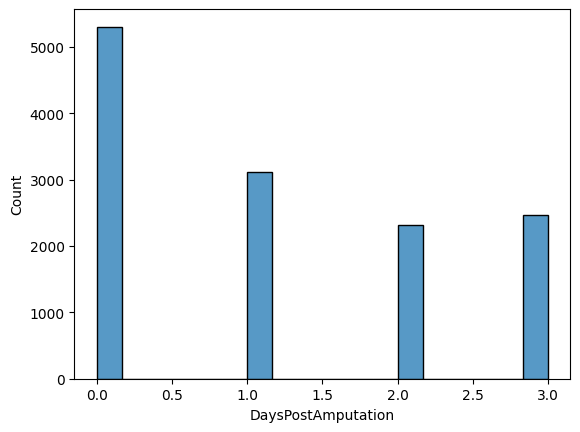

In [9]:
import seaborn as sns
sns.histplot(adata.obs['DaysPostAmputation'])



**`Selecting timepoint 0 (Day of amputation).`**

In [10]:
adata = adata[adata.obs['DaysPostAmputation'] == 0] # Subset on the time point 0

In [11]:
adata.layers['counts'] = adata.X.copy() # Copy the raw counts in a different layer

<ipython-input-11-7fc776284790>:1: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers['counts'] = adata.X.copy() # Copy the raw counts in a different layer


**Normalize and lognize filtered data**

In [12]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_cells(adata, min_genes=200)



In [13]:
import scipy.sparse
if scipy.sparse.issparse(adata.X):
    print("adata.X is a sparse matrix.")
else:
    print("adata.X is a dense matrix.")

adata.X is a sparse matrix.


**Select high variance gene from the filtered data.**

In [14]:
import numpy as np
X_dense = adata.X.toarray()
adata.var['mean_expression'] = np.mean(X_dense, axis=0)
adata.var['variance'] = np.var(X_dense, axis=0)

# Calculate the Fano factor (variance / mean)
adata.var['fano_factor'] = adata.var['variance'] / adata.var['mean_expression']


In [15]:
fano_65th_percentile = np.percentile(adata.var['fano_factor'], 65)
print(fano_65th_percentile)
high_variance_genes=adata.var['fano_factor'] > fano_65th_percentile

lowly_expressed_threshold = np.percentile(adata.var['mean_expression'], 5)
not_lowly_expressed = adata.var['mean_expression'] >= lowly_expressed_threshold

highly_expressed_threshold = np.percentile(adata.var['mean_expression'], 80)
not_highly_expressed = adata.var['mean_expression'] <= highly_expressed_threshold

selected_genes = high_variance_genes & not_lowly_expressed & not_highly_expressed

hvg_adata = adata[:, selected_genes]
hvg_adata.shape

0.9059803839727745


(5302, 6905)

## PCA Analysis and Visulization



In [16]:
# Scale data
sc.pp.scale(hvg_adata)


/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [17]:
# Do PCA on the highly variable genes data
sc.tl.pca(hvg_adata)

In [18]:
sc.pp.pca(hvg_adata)

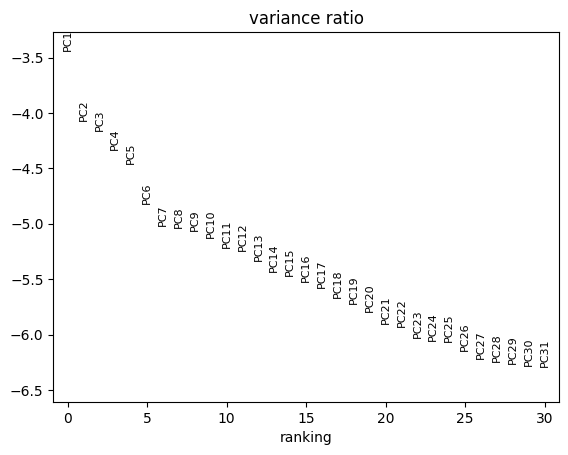

In [19]:
sc.pl.pca_variance_ratio(hvg_adata, log=True) # Plot the variance ratio

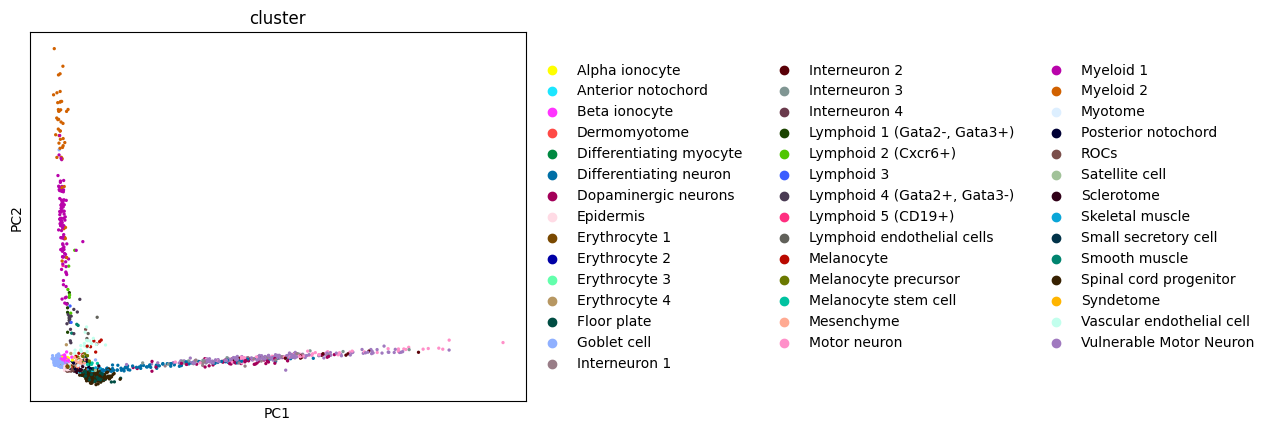

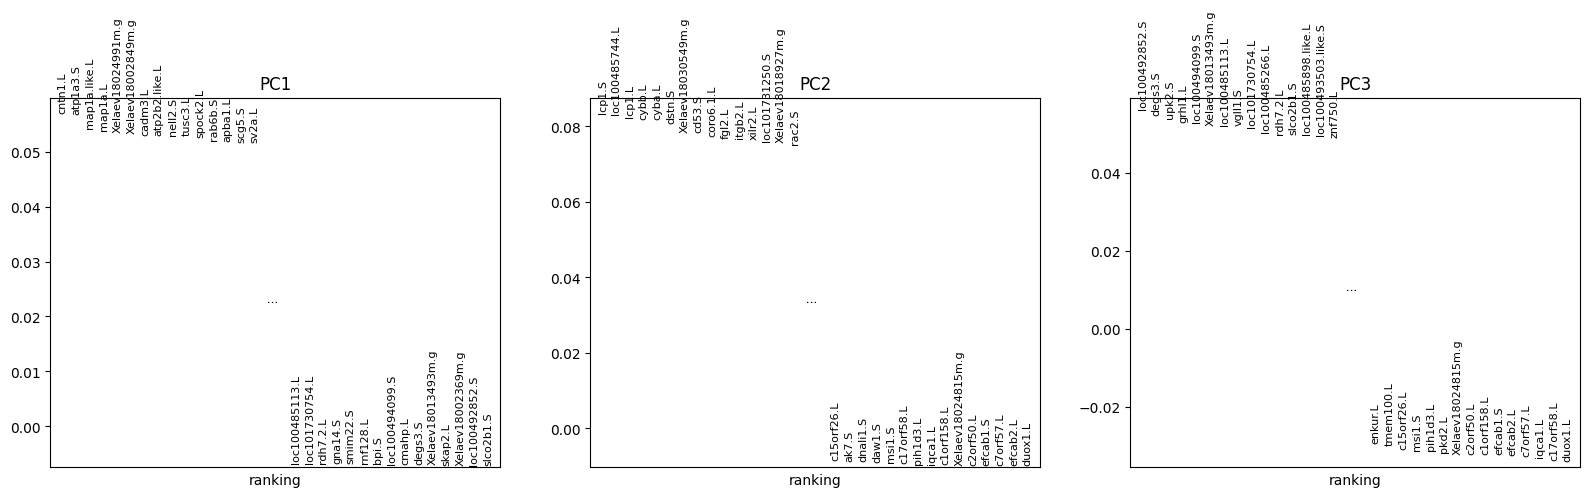

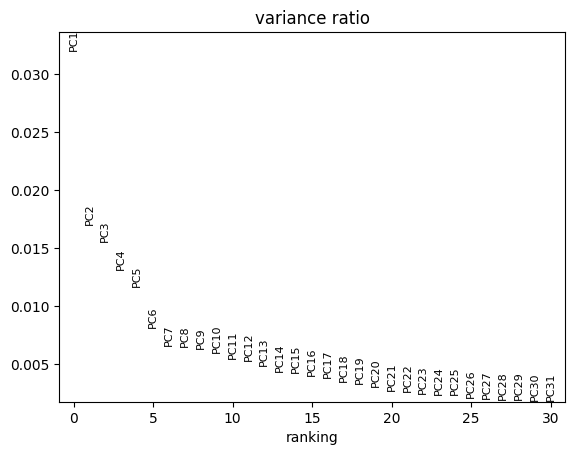

In [20]:
sc.pl.pca_overview(hvg_adata, color='cluster', components= ['1,2']) # Plot all diagnostics including PC1 against PC2 and PC2 against PC3

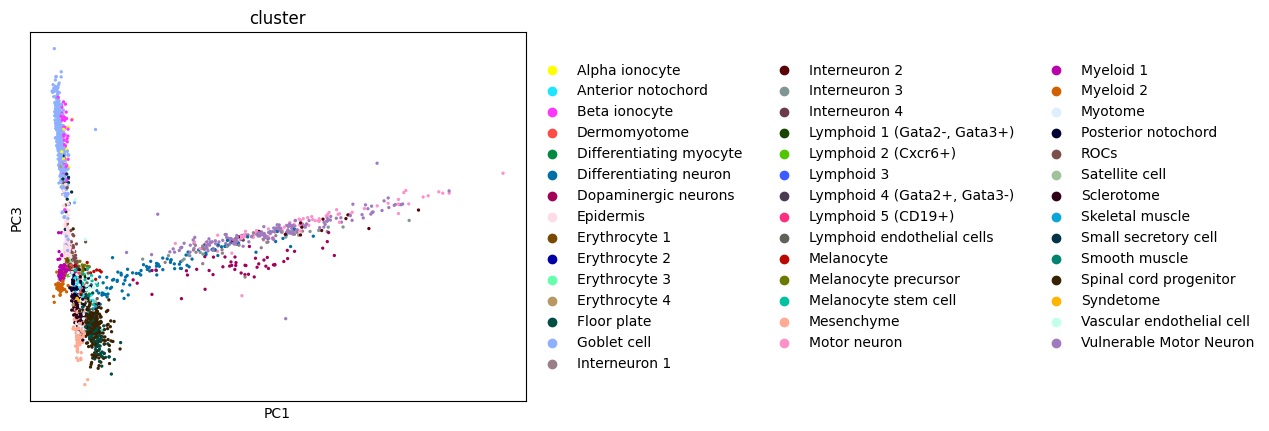

In [21]:
sc.pl.pca(hvg_adata, color='cluster', components= ['1,3']) # Plot all diagnostics including PC1 against PC2 and PC2 against PC3


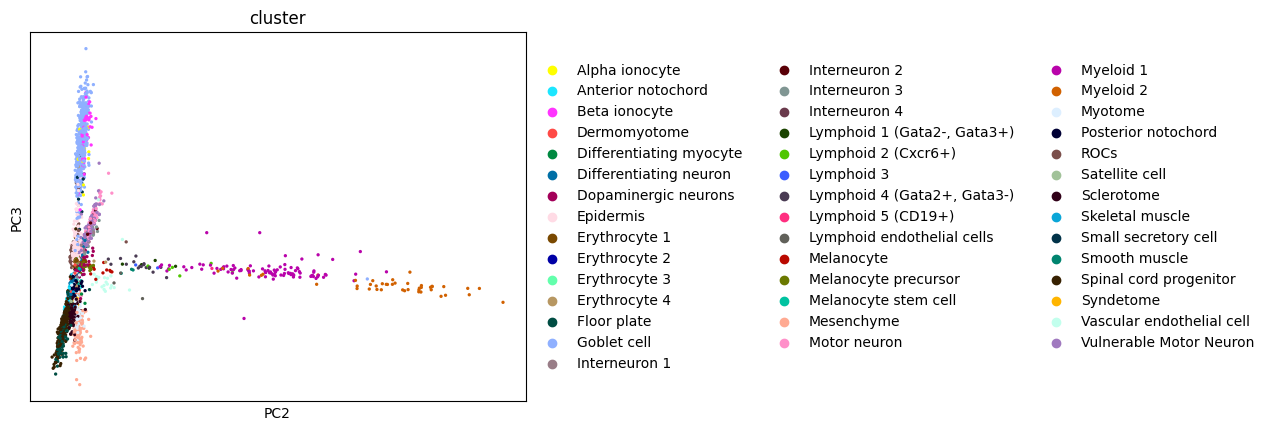

In [22]:
sc.pl.pca(hvg_adata, color='cluster', components= ['2,3']) # Plot all diagnostics including PC1 against PC2 and PC2 against PC3


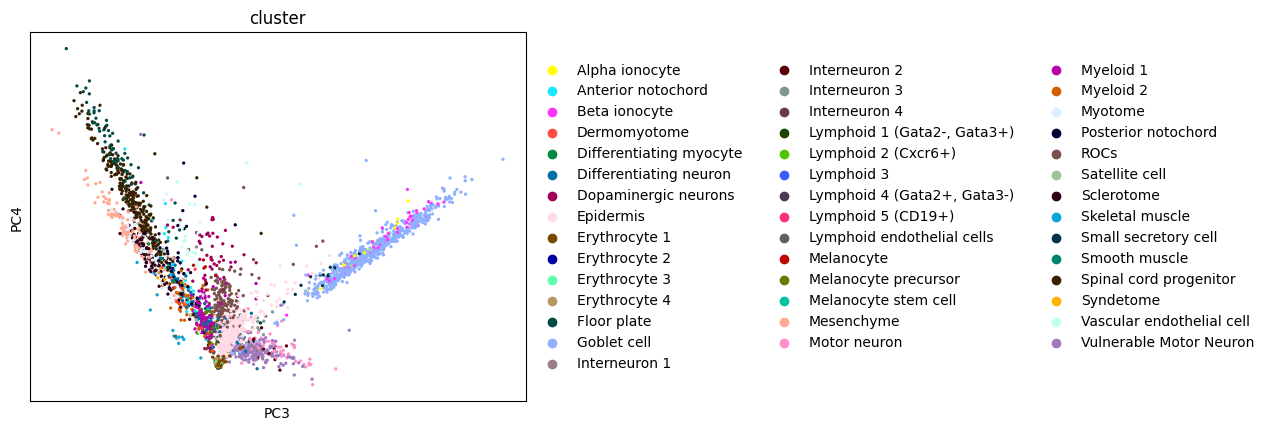

In [23]:
sc.pl.pca(hvg_adata, color='cluster', components= ['3,4']) # Plot all diagnostics including PC1 against PC2 and PC2 against PC3


## Apply clustering Analysis -- Leiden & Louvain & Kmeans

In [24]:
# Whitening step - create neighbors graph based on PCA
sc.pp.neighbors(hvg_adata, n_pcs=7) # Create neighbors graph - n_pcs takes the number of principal components from PCA you keep for this step
sc.tl.leiden(hvg_adata, resolution=0.5)  # Apply Leiden clustering, you can adjust the resolution parameter


<ipython-input-24-0291f543527e>:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(hvg_adata, resolution=0.5)  # Apply Leiden clustering, you can adjust the resolution parameter


In [25]:
sc.tl.louvain(hvg_adata, resolution=1)

In [26]:
palette = ['red' if c == 'ROCs' else 'blue'  for c in adata.obs['cluster']]
hvg_adata.obs['rocs']=palette

In [27]:
sc.tl.umap(hvg_adata)


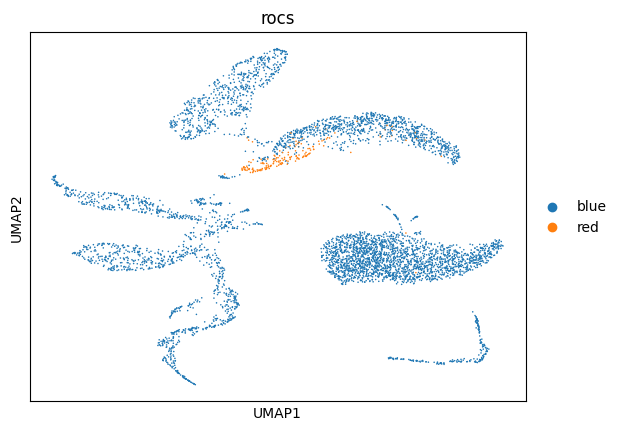

In [28]:
sc.pl.umap(
    hvg_adata,
    color='rocs',
    size=5
)

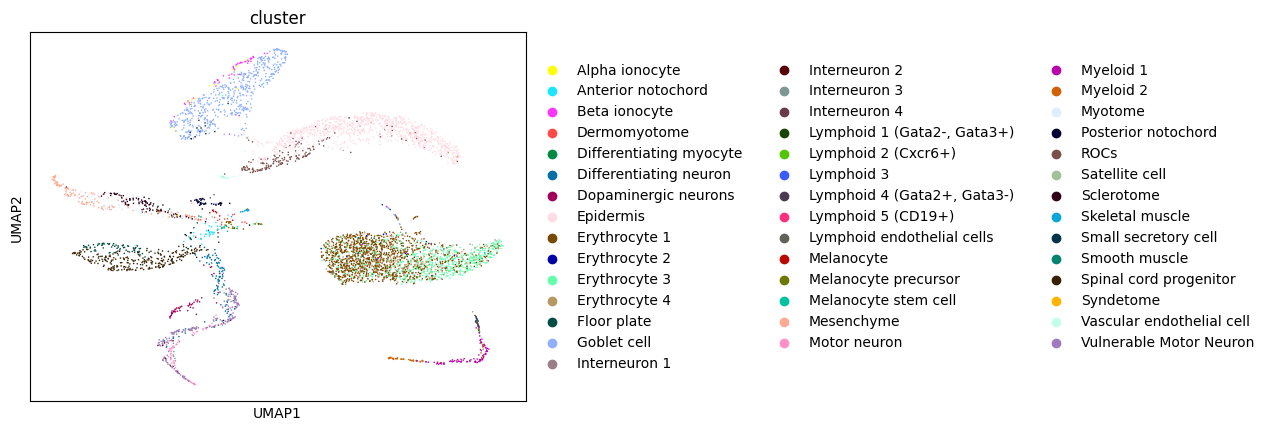

In [29]:
sc.pl.umap(
    hvg_adata,
    color="cluster",
    size=5,
)

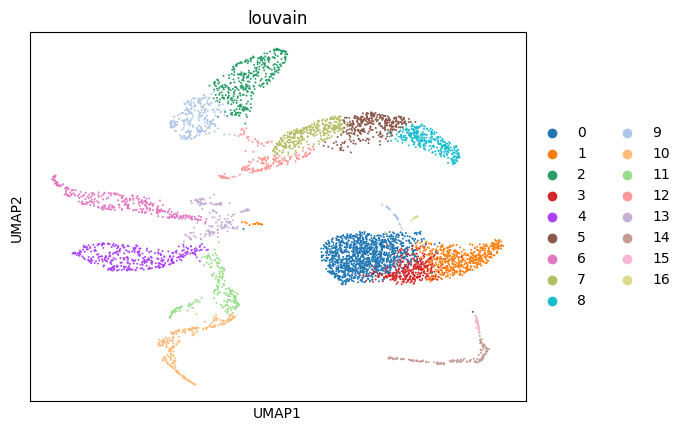

In [30]:
sc.pl.umap(
    hvg_adata,
    color=["louvain"],
    size=8
)

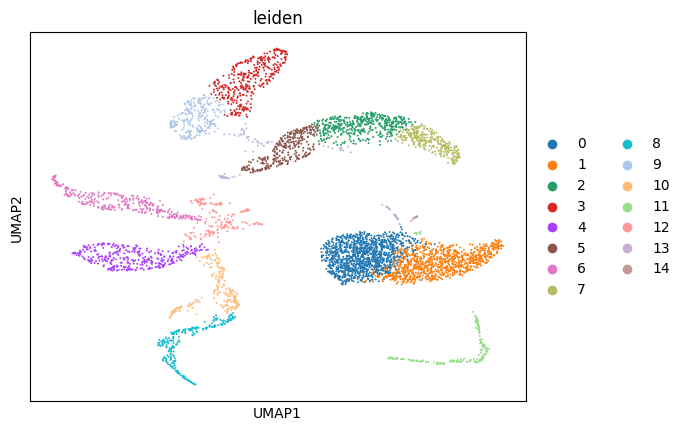

In [31]:
sc.pl.umap(
    hvg_adata,
    color="leiden",
    size=8
)

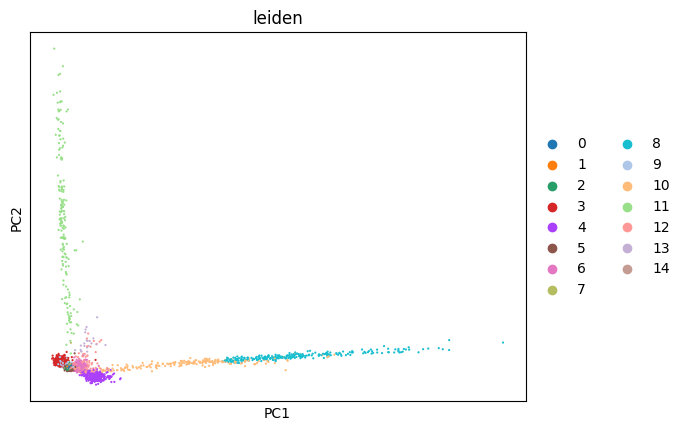

In [32]:
sc.pl.pca(hvg_adata, color=['leiden'],size=10) # Plotting PC1/PC2 with colors from Leiden labels


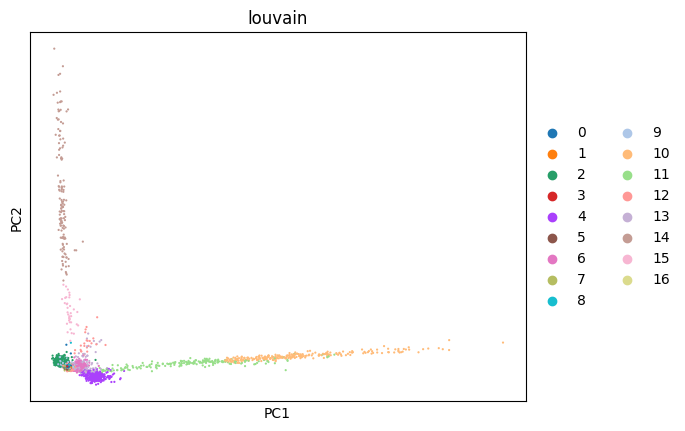

In [33]:
sc.pl.pca(hvg_adata, color=['louvain'],size=10) # Plotting PC1/PC2 with colors from Leiden labels


In [34]:
for res in [0.02, 0.5, 1.0, 2.0]:
    sc.tl.leiden(
        hvg_adata, key_added=f"leiden_res_{res:4.2f}", resolution=res, flavor="igraph"
    )



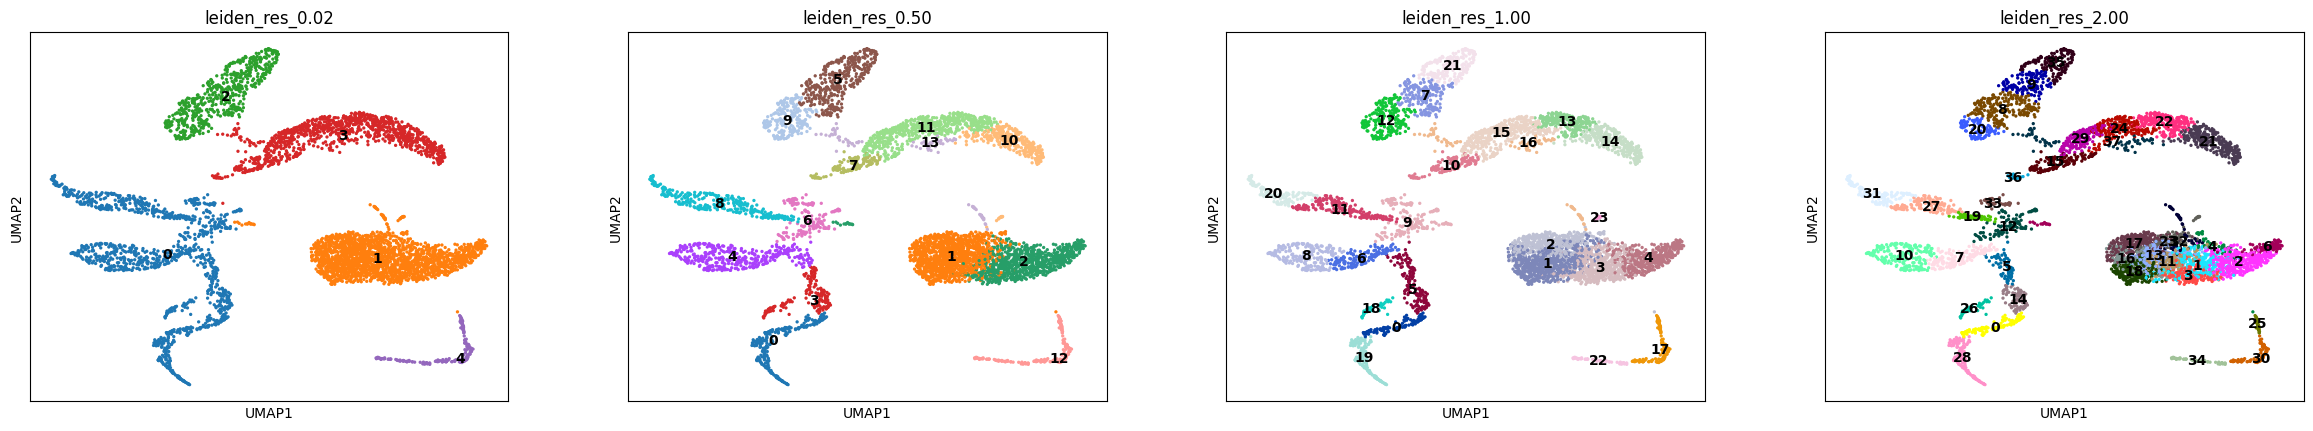

In [35]:
sc.pl.umap(
    hvg_adata,
    color=["leiden_res_0.02", "leiden_res_0.50", "leiden_res_1.00","leiden_res_2.00"],
    legend_loc="on data",
)

In [36]:
for res in [0.02, 0.5, 1.0, 2.0]:
    sc.tl.louvain(
        hvg_adata, key_added=f"louvain_res_{res:4.2f}", resolution=res
    )

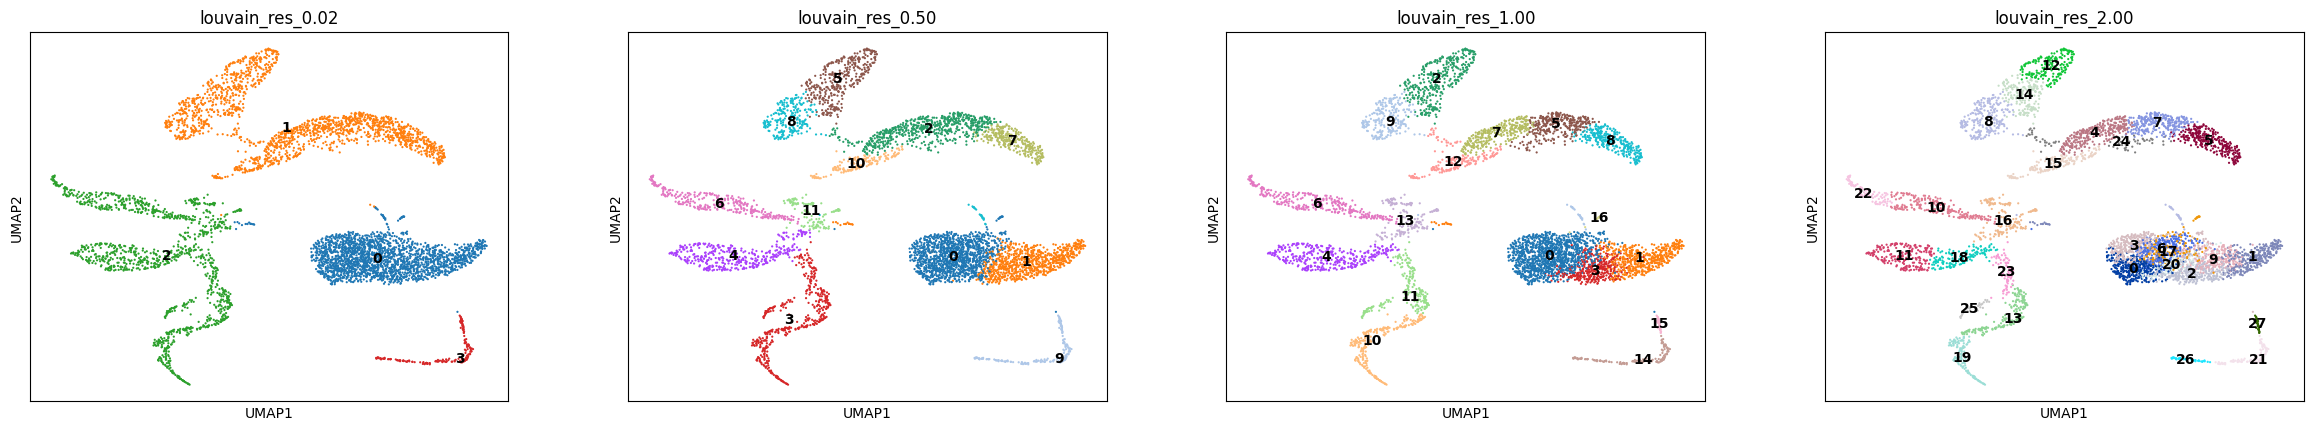

In [37]:
sc.pl.umap(
    hvg_adata,
    color=["louvain_res_0.02", "louvain_res_0.50", "louvain_res_1.00","louvain_res_2.00"],
    legend_loc="on data",size=10)

In [38]:
from sklearn.cluster import KMeans
X = hvg_adata.obsm['X_pca']  # Using PCA data for KMeans clustering (optional)

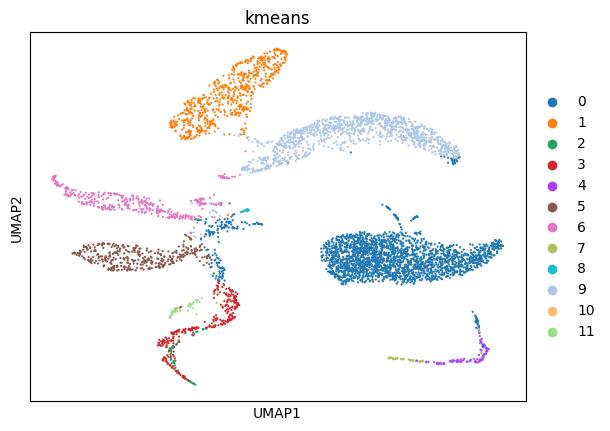

In [39]:
# Apply KMeans clustering (specify the number of clusters k)
kmeans = KMeans(n_clusters=12, random_state=0)  # Set the number of clusters
hvg_adata.obs['kmeans'] = kmeans.fit_predict(X).astype(str)  # Store cluster labels in adata.obs

# Visualize clusters
sc.pl.umap(hvg_adata, color='kmeans',size=10)

In [40]:
# Apply KMeans clustering (specify the number of clusters k)
kmeans = KMeans(n_clusters=12, random_state=0)  # Set the number of clusters
hvg_adata.obs['kmeans'] = kmeans.fit_predict(hvg_adata).astype(str)  # Store cluster labels in adata.obs

# Visualize clusters
sc.pl.umap(hvg_adata, color='kmeans',size=10)

KeyboardInterrupt: 

**Compute the cluster metrics**

In [41]:
from sklearn.metrics import adjusted_rand_score, silhouette_score, rand_score


In [42]:
rand_index = rand_score(hvg_adata.obs['cluster'], hvg_adata.obs['leiden'])
print(f"Rand Index for Leiden clustering: {rand_index}")

Rand Index for Leiden clustering: 0.8957813913960135


In [43]:
rand_index = rand_score(hvg_adata.obs['cluster'], hvg_adata.obs['louvain'])
print(f"Rand Index for Louvain clustering: {rand_index}")

Rand Index for Louvain clustering: 0.8984312974548905


In [44]:
# Use PCA-reduced data or the original data
X = hvg_adata.obsm['X_pca']  # or adata.X for original data

# Compute silhouette score for Leiden clustering
silhouette_avg = silhouette_score(hvg_adata.X, hvg_adata.obs['leiden'].astype(int))
print(f"Silhouette score for Leiden clustering: {silhouette_avg}")

Silhouette score for Leiden clustering: -0.16321793965972603


In [45]:
silhouette_avg_louvain = silhouette_score(hvg_adata.X, hvg_adata.obs['louvain'].astype(int))
print(f"Silhouette score for Louvain clustering: {silhouette_avg_louvain}")

Silhouette score for Louvain clustering: -0.18466762127614428


In [46]:
# Adjusted Rand Index (ARI)
ari_leiden = adjusted_rand_score(hvg_adata.obs['cluster'], hvg_adata.obs['leiden'])
ari_louvain = adjusted_rand_score(hvg_adata.obs['cluster'], hvg_adata.obs['louvain'])


print(f"ARI for Leiden: {ari_leiden}, ARI for Louvain: {ari_louvain}")


ARI for Leiden: 0.4770095454682358, ARI for Louvain: 0.45992050410326724


# Gene Analysis
We try three methods to get gene marker and compare their results.
1. Logistic Regression
2. wilcoxon
3. t-test


Visualize the gene marker for each group

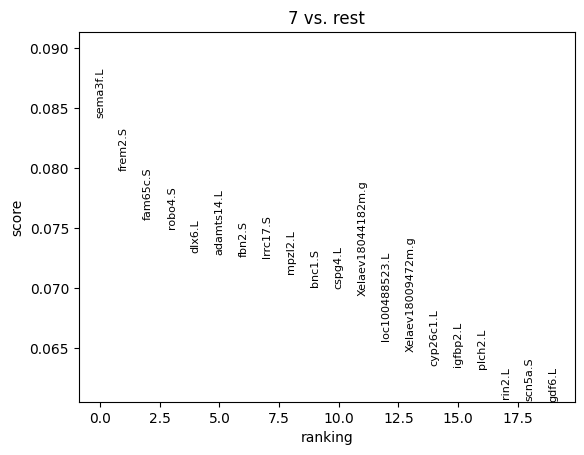

In [84]:
sc.tl.rank_genes_groups(hvg_adata, groupby="leiden_res_0.50",method="logreg",  max_iter = 1000)
sc.pl.rank_genes_groups(hvg_adata, groups=["7"], n_genes=20)

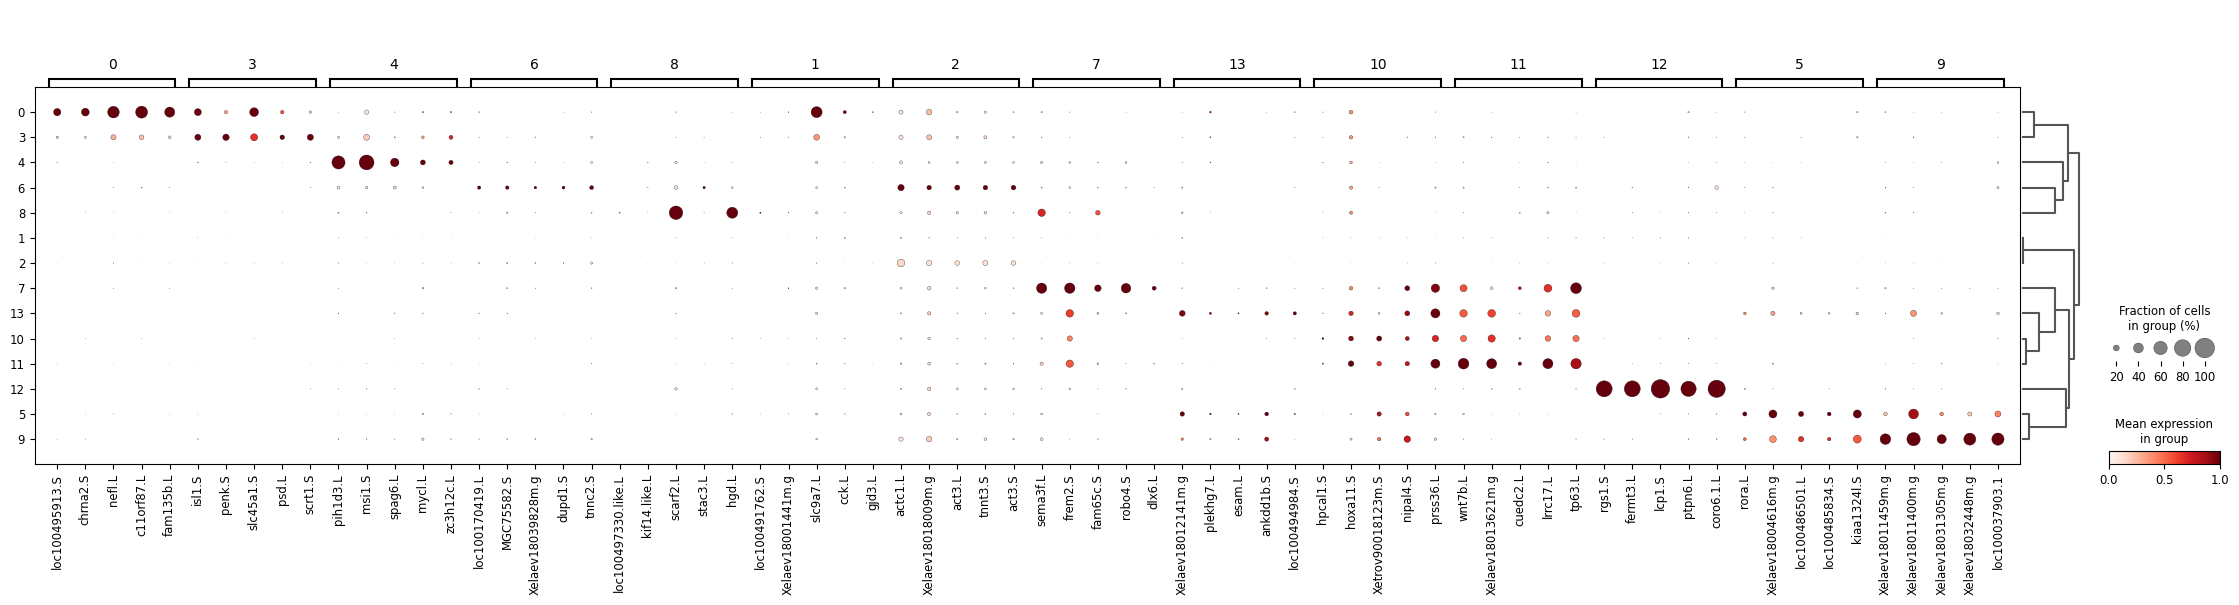

In [85]:
sc.pl.rank_genes_groups_dotplot(
    hvg_adata, groupby="leiden_res_0.50", standard_scale="var", n_genes=5
)

In [76]:
# Subset your data for group 7 and all other groups
group_7 = hvg_adata[hvg_adata.obs['leiden_res_0.50'] == '7']  # Subset for group 7
other_groups = hvg_adata[hvg_adata.obs['leiden_res_0.50'] != '7']  # Subset for the rest of the data

# Check if there are cells in both group 7 and other clusters
print(f"Number of cells in group 7: {group_7.shape[0]}")
print(f"Number of cells in other groups: {other_groups.shape[0]}")

# Ensure there are cells in both groups before proceeding
if group_7.shape[0] > 0 and other_groups.shape[0] > 0:
    # Proceed with logistic regression
    X = np.vstack([group_7.X, other_groups.X])  # Combine expression data
    y = np.hstack([np.ones(group_7.shape[0]), np.zeros(other_groups.shape[0])])  # 1 for group 7, 0 for others

    # Logistic Regression model
    log_reg = LogisticRegression(max_iter=1000)

    # Fit the model
    log_reg.fit(X, y)

    # Get the top marker genes (based on the coefficients of logistic regression)
    marker_genes_idx = np.argsort(np.abs(log_reg.coef_)).flatten()[:50]

    # Get the gene names from the AnnData object (using var_names)
    top_marker_gene_names = adata.var_names[marker_genes_idx]

    # Print the top marker gene names
    print("Top marker genes for group 7:", top_marker_gene_names)
else:
    print("Error: One of the groups is empty. Logistic regression cannot be performed.")


Number of cells in group 7: 132
Number of cells in other groups: 5170
Top marker genes for group 7: Index(['hpse.L', 'Xelaev18011904m.g', 'cdkn1a.L', 'ntrk2.S',
       'Xelaev18006368m.g', 'loc100496613.L', 'dapk1.S', 'Xelaev18001030m.g',
       'kcmf1.L', 'Xelaev18012615m.g', 'loc548788.S', 'gpalpp1.L',
       'Xelaev18006990m.g', 'Xetrov90004519m.L', 'Xelaev18013576m.g',
       'srpk1.S', 'kcnn4.S', 'Xelaev18002199m.g', 'loc101732704.S',
       'grin3a.like.L', 'loc100492708', 'trim36.L', 'Xelaev18012629m.g',
       'serpind1.L', 'Xelaev18002161m.g', 'pias4.S', 'Xelaev18006182m.g',
       'Xelaev18011919m.g', 'Xelaev18001103m.g', 'gng10.L', 'kiaa0020.S',
       'asphd2.L', 'gdpd5.L', 'gltp.S', 'nadk2.L', 'mpdu1.S', 'ctc1.S',
       'loc100485387.like.1.L', 'Xelaev18013290m.g', 'Xelaev18011044m.g',
       'pcdh18.S', 'cryaa.S', 'klhl22.S', 'Xelaev18009170m.g',
       'Xelaev18011992m.g', 'Xelaev18001140m.g', 'dnali1.L', 'dach1.L',
       'ndst4.S', 'kiaa1671.L'],
      dtype='object')

/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


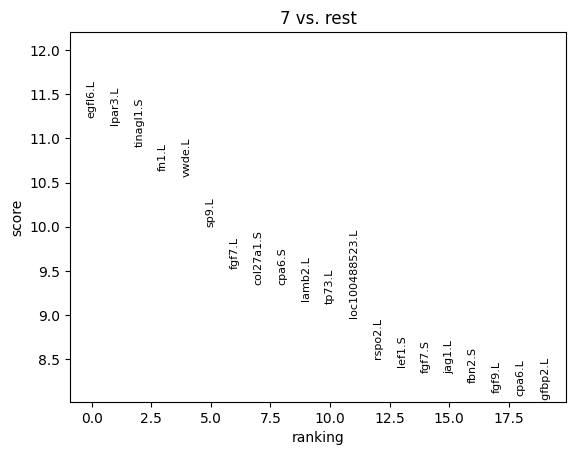

In [78]:
sc.tl.rank_genes_groups(hvg_adata, "leiden_res_0.50", groups=["7"], reference='rest', method="wilcoxon")
sc.pl.rank_genes_groups(hvg_adata, groups=["7"], n_genes=20)

In [80]:
# Retrieve the names of the top marker genes for group 7
top_genes_group_7_w = hvg_adata.uns['rank_genes_groups']['names']['7'][:50]

# Print the gene names
print("Top marker genes for group 7:", top_genes_group_7_w)

Top marker genes for group 7: ['egfl6.L' 'lpar3.L' 'tinagl1.S' 'fn1.L' 'vwde.L' 'sp9.L' 'fgf7.L'
 'col27a1.S' 'cpa6.S' 'lamb2.L' 'tp73.L' 'loc100488523.L' 'rspo2.L'
 'lef1.S' 'fgf7.S' 'jag1.L' 'fbn2.S' 'fgf9.L' 'cpa6.L' 'igfbp2.L'
 'Xelaev18034799m.g' 'kank3.L' 'dlx2.L' 'dlx2.S' 'Xelaev18044182m.g'
 'nid2.S' 'ism2.L' 'Xelaev18046800m.g' 'sema3f.L' 'tp63.L' 'nckap5l.L'
 'robo4.S' 'wnt5a.S' 'kremen2.L' 'robo4.L' 'frem2.S' 'mmp28.L' 'ecm1.L'
 'lef1.L' 'ehd2.S' 'fgfr4.L' 'unc5b.S' 'loc100498358.L' 'prss35.S'
 'fzd10.L' 'c3.L' 'krt.L' 'gpx8.S' 'loc100492954.S' 'cyp8b1.S']


In [90]:
top_genes_group_7_w

array(['egfl6.L', 'lpar3.L', 'tinagl1.S', 'fn1.L', 'vwde.L', 'sp9.L',
       'fgf7.L', 'col27a1.S', 'cpa6.S', 'lamb2.L', 'tp73.L',
       'loc100488523.L', 'rspo2.L', 'lef1.S', 'fgf7.S', 'jag1.L',
       'fbn2.S', 'fgf9.L', 'cpa6.L', 'igfbp2.L', 'Xelaev18034799m.g',
       'kank3.L', 'dlx2.L', 'dlx2.S', 'Xelaev18044182m.g', 'nid2.S',
       'ism2.L', 'Xelaev18046800m.g', 'sema3f.L', 'tp63.L', 'nckap5l.L',
       'robo4.S', 'wnt5a.S', 'kremen2.L', 'robo4.L', 'frem2.S', 'mmp28.L',
       'ecm1.L', 'lef1.L', 'ehd2.S', 'fgfr4.L', 'unc5b.S',
       'loc100498358.L', 'prss35.S', 'fzd10.L', 'c3.L', 'krt.L', 'gpx8.S',
       'loc100492954.S', 'cyp8b1.S'], dtype=object)

/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


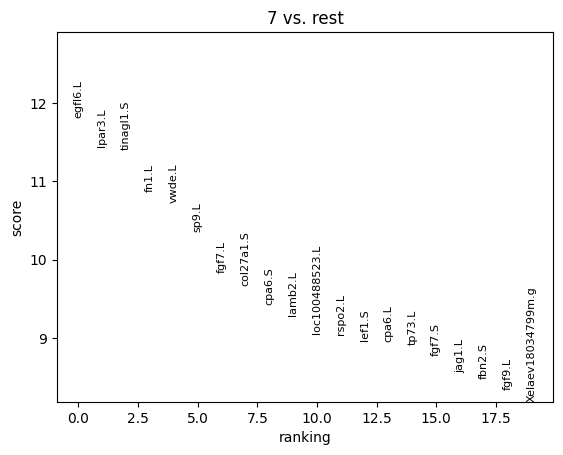

In [81]:
sc.tl.rank_genes_groups(hvg_adata, "leiden_res_0.50", groups=["7"], reference='rest', method="t-test")
sc.pl.rank_genes_groups(hvg_adata, groups=["7"], n_genes=20)

In [82]:
# Retrieve the names of the top marker genes for group 7
top_genes_group_7_t = hvg_adata.uns['rank_genes_groups']['names']['7'][:50]

# Print the gene names
print("Top marker genes for group 7:", top_genes_group_7_t)

Top marker genes for group 7: ['egfl6.L' 'lpar3.L' 'tinagl1.S' 'fn1.L' 'vwde.L' 'sp9.L' 'fgf7.L'
 'col27a1.S' 'cpa6.S' 'lamb2.L' 'loc100488523.L' 'rspo2.L' 'lef1.S'
 'cpa6.L' 'tp73.L' 'fgf7.S' 'jag1.L' 'fbn2.S' 'fgf9.L' 'Xelaev18034799m.g'
 'sema3f.L' 'Xelaev18046800m.g' 'kank3.L' 'nid2.S' 'igfbp2.L' 'robo4.S'
 'Xelaev18044182m.g' 'dlx2.L' 'dlx2.S' 'wnt5a.S' 'mmp28.L' 'frem2.S'
 'fgfr4.L' 'c3.L' 'kremen2.L' 'ism2.L' 'nckap5l.L' 'loc100498358.L'
 'lef1.L' 'robo4.L' 'tp63.L' 'ehd2.S' 'unc5b.S' 'prss35.S' 'ecm1.L'
 'fzd10.L' 'gpx8.S' 'cyp8b1.S' 'gdf6.L' 'loc100492954.S']


**Compare the rank genes with marker genes in the paper**

In [98]:
import pandas as pd

new_file_path = '/content/drive/MyDrive/MarkerList(SuppTable3).xlsx'

roc_genes_new_df = pd.read_excel(new_file_path, sheet_name='ROC markers',header=None)

# Display the first few rows of the 'ROC markers' sheet to understand its structure
roc_genes_new_df

,0
0,wnt5a
1,loc100488523
2,loc100492954
3,egfl6
4,lpar3
5,cpa6
6,sp9
7,fgf9
8,fbn2
9,tinagl1


In [108]:
# Remove suffixes like ".L", ".S" from the marker genes
cleaned_marker_genes_w = [gene.split('.')[0] for gene in top_genes_group_7_w]

common_genes_w = set(roc_genes_new_df[0]).intersection(set(cleaned_marker_genes_w))

# Count how many genes are the same
num_common_genes_w = len(common_genes_w)
print(num_common_genes_w)

32


In [109]:
cleaned_marker_genes_t = [gene.split('.')[0] for gene in top_genes_group_7_t]

common_genes_t = set(roc_genes_new_df[0]).intersection(set(cleaned_marker_genes_t))


# Count how many genes are the same
num_common_genes_t = len(common_genes_t)
print(num_common_genes_t)

32


In [110]:
cleaned_marker_genes_l = [gene.split('.')[0] for gene in top_marker_gene_names]

common_genes_l = set(cleaned_marker_genes_l).intersection(set(roc_genes_new_df[0]))

# Count how many genes are the same
num_common_genes_l = len(common_genes_l)
print(num_common_genes_l)

0
